In [5]:
import numpy as np
import pandas as pd 
import json
import copy
import jieba
import time

In [2]:
class oneweibo:
    def __init__(self,
                id,
                user_id,
                is_retweet, #是否转发
                user_type,
                user_name,
                weibo_content,
                r_weibo_content,
                region_name, #ip属地
                time,
                zhuan=0,
                ping=0,
                zhan=0):
        self.id=id 
        self.user_id=user_id
        self.is_retweet=is_retweet
        self.user_type=user_type
        self.user_name=user_name
        self.weibo_content=weibo_content 
        self.r_weibo_content=r_weibo_content
        self.time=time 
        self.zhuan=zhuan 
        self.ping=ping 
        self.zhan=zhan 
        
    def show(self):
        print(
            "id:",self.id,
            "user_id:",self.user_id,
            "is_retweet:",self.is_retweet,
            "user_type:",self.user_type,
            "user_name:",self.user_name,
            "weibo_content:",self.weibo_content,
            "time:",self.time,
            "zhuan",self.zhuan,
            "ping:",self.ping,
            "zhan:",self.zhan
        )
    def __eq__(self,other): 
        return self.weibo_content==other.weibo_content
        

In [3]:
class Vertex:
    def __init__(self,
                user_id,
                user_name,
                user_type):
        self.user_id=user_id
        self.user_name=user_name 
        self.user_type=user_type
        self.weibos={} #发的微博
        self.connectedTo={} #转发关系

    def tweeting(self,wb): #发微博
        self.weibos[wb.id]=wb 

    def getWeibo(self,id):  #根据微博id返回微博
        if id in self.weibos:
            return self.weibos[id]
        else:
            return None
    
    def showeibo(self):
        for key in self.weibos.keys():
            self.weibos[key].show()

    def addNeighbor(self,nbr_id):
        if nbr_id not in self.connectedTo.keys():
            self.connectedTo[nbr_id]=1
        else:
            self.connectedTo[nbr_id]=self.connectedTo[nbr_id]+1 #多次转发，关系更强

In [5]:
class Graph:
    def __init__(self):
        self.verList={} #user_id:节点
        self.numVertices=0
    
    def addVertex(self,
                user_id,
                user_name,
                user_type):
        self.numVertices=self.numVertices+1
        newVertex=Vertex(user_id,
                        user_name,
                        user_type)
        self.verList[user_id]=newVertex
        return newVertex

    def getVertex(self,user_id):
        if user_id in self.verList:
            return self.verList[user_id]
        else:
            return None
            
    def updateVertex(self,
                    id,
                    user_id,
                    is_retweet,
                    user_type,
                    user_name,
                    weibo_content,
                    r_weibo_content,
                    region_name,
                    time,
                    zhuan,
                    ping,
                    zhan):
        node=Graph.getVertex(self,user_id)
        wb=oneweibo(id,user_id,is_retweet,user_type,user_name,
        weibo_content,r_weibo_content,region_name,time,zhuan,ping,zhan)
        node.tweeting(wb)
        
    def __contains__(self,id):
        return id in self.verList

    def addEdge(self,f_id,t_id): 
        #这里写错了，
        #self.verList[f_id].addNeighbor(t_id)
        self.verList[f_id].addNeighbor(t_id)
    
    def getVertices(self):
        return self.verList.keys()
    def __iter__(self):
        return iter(self.verList.values())

In [9]:
def exist(texts,keyword):
    for word in keyword:
        for text in texts:
            if word in text:
                return True
    return False

In [7]:
from functools import partial
 
def read_from_file(filename, block_size = 1024 * 8):
    with open(filename, "r") as fp:
        for chunk in iter(partial(fp.read, block_size), ""):
            yield chunk

In [11]:
import xlsxwriter as xw
import time

In [95]:
g=read_from_file('weibo_freshdata.2022-10-08/weibo_freshdata.2022-10-08',1024*16)

In [12]:
workbook=xw.Workbook("ans.xlsx")
worksheet1=workbook.add_worksheet("sheet1")
worksheet1.activate()
title=['wb_id','time_stamp','user_id','user_name','user_type','is_retweet','wb_content','device','edit','video','region_name','r_wb_id','zhuan','ping','zhan']
worksheet1.write_row("A1",title)
i=2
left=''
t1=time.time()
for chunk in read_from_file('weibo_freshdata.2022-10-08/weibo_freshdata.2022-10-08',1024*16):
    l=chunk.split('\n') 
    break
    #换行符可能出现在开头/结尾
    if l[-1]=='': 
        l.pop(-1)
    if l[0]=='':
        l.pop(0)
    l[0]=left+l[0] #上一次未读完的补齐

    if len(l[-1])<13: #未涉及{}
        left=l[-1]  
        if len(l)<1 or len(l)==1:
            continue
        l=[eval(i[12:]) for i in l[:-1]]
    else:
        try:
            eval(l[-1][12:])
        except SyntaxError:
            left=l[-1]  #剩下的部分
            if len(l)<1 or len(l)==1:
                continue
            l=[eval(i[12:]) for i in l[:-1]]
        else:
            left=''
            l=[eval(i[12:]) for i in l]

    to_find=[piece['weibo_content']+piece['r_weibo_content'] for piece in l]
    qualified_index=[i for i in range(len(to_find)) if exist(to_find[i],keyword)]
    for d in qualified_index:
        region_name=' '
        if 'ext' in l[d].keys():
            region_name=json.loads(l[d]['ext'])['region_name'].split()[-1] if 'region_name' in json.loads(l[d]['ext']).keys() else ' '
        insertData=[l[d]['weibo_id'],l[d]['time_stamp'],l[d]['user_id'],l[d]['nick_name'],l[d]['user_type'],l[d]['is_retweet'],l[d]['weibo_content'],l[d]['device'],l[d]['edited'],l[d]['vedio'],region_name,l[d]['r_weibo_id'],l[d]['zhuan'],l[d]['ping'],l[d]['zhan']]
        row='A'+str(i)
        worksheet1.write_row(row,insertData)
        i+=1
workbook.close()
t2=time.time()
print(t2-t1)

0.1416771411895752


In [13]:
l[-2]

'75640178358\t{"id":"75640178358","crawler_time":"2022-10-08 00:00:00","crawler_time_stamp":"1665158400000","is_retweet":"0","user_id":"1454303565","nick_name":"希阳西","tou_xiang":"https:\\/\\/tvax2.sinaimg.cn\\/crop.0.0.512.512.50\\/56aee94dly8gjewniter9j20e80e8jsa.jpg?KID=imgbed,tva&Expires=1665169199&ssig=G7HjHOHM1q","user_type":"普通用户","weibo_id":"4822065498821328","weibo_content":"#肖战[超话]##肖战时影#[心]#肖战肖春生# \\n韶华流光里，\\n俯仰皆是你@X玖少年团肖战DAYTOY @X玖少年团肖战DAYTOY [心][兔子][贊啊]#肖战顺顺利利# \u200b\u200b\u200b","zhuan":"0","ping":"1","zhan":"1","url":"M9g1vB0Pu","device":"肖戰順順利利","locate":"","time":"2022-10-07 22:37:47","time_stamp":"1665153467","r_user_id":"","r_nick_name":"","r_user_type":"","r_weibo_id":"","r_weibo_content":"","r_zhuan":"","r_ping":"","r_zhan":"","r_url":"","r_device":"","r_location":"","r_time":"","r_time_stamp":"","pic_content":"56aee94dgy1h6x3jo6vz7j236c2jxkjl","src":"4","tag":"0","vedio":"0","vedio_image":"","edited":"0","r_edited":"","isLongText":"0","r_isLongText":"","lat":"","l

In [11]:
l=chunk.split('\n')
l=[i[12:] for i in l]
pd.DataFrame(l[:-1])

,0
0,"{""id"":""75640178330"",""crawler_time"":""2022-10-08..."
1,"{""id"":""75640178331"",""crawler_time"":""2022-10-08..."
2,"{""id"":""75640178332"",""crawler_time"":""2022-10-08..."
3,"{""id"":""75640178333"",""crawler_time"":""2022-10-08..."
4,"{""id"":""75640178334"",""crawler_time"":""2022-10-08..."
5,"{""id"":""75640178335"",""crawler_time"":""2022-10-08..."
6,"{""id"":""75640178336"",""crawler_time"":""2022-10-08..."
7,"{""id"":""75640178337"",""crawler_time"":""2022-10-08..."
8,"{""id"":""75640178338"",""crawler_time"":""2022-10-08..."
9,"{""id"":""75640178339"",""crawler_time"":""2022-10-08..."


## 按块读取，存list，找

In [173]:
workbook=xw.Workbook("ans.xlsx")
worksheet1=workbook.add_worksheet("sheet1")
worksheet1.activate()
title=['wb_id','time_stamp','user_id','user_name','user_type','is_retweet','wb_content','device','edit','video','region_name','r_wb_id','zhuan','ping','zhan']
worksheet1.write_row("A1",title)
i=2
left=''
t1=time.time()
for chunk in read_from_file('weibo_freshdata.2022-10-08/weibo_freshdata.2022-10-08',1024*16):

    l=chunk.split('\n') 
    #换行符可能出现在开头/结尾
    if l[-1]=='': 
        l.pop(-1)
    if l[0]=='':
        l.pop(0)
    l[0]=left+l[0] #上一次未读完的补齐

    if len(l[-1])<13: #未涉及{}
        left=l[-1]  
        if len(l)<1 or len(l)==1:
            continue
        l=[eval(i[12:]) for i in l[:-1]]
    else:
        try:
            eval(l[-1][12:])
        except SyntaxError:
            left=l[-1]  #剩下的部分
            if len(l)<1 or len(l)==1:
                continue
            l=[eval(i[12:]) for i in l[:-1]]
        else:
            left=''
            l=[eval(i[12:]) for i in l]

    to_find=[piece['weibo_content']+piece['r_weibo_content'] for piece in l]
t2=time.time()
print(t2-t1)

5107.944137096405


In [ ]:
import re
keyword1=['北京疫情发布会','上海疫情发布会','上海市新冠肺炎疫情防控新闻发布会','上海疫情防控工作发布会','上海疫情防控发布会','广州市疫情防控发布会']
keyword2=['重庆市政府新闻发布会','疫情']
for chunk in read_from_file('weibo_freshdata.2022-10-08/weibo_freshdata.2022-10-08',1024*16):
    pattern1=re.compile('|'.join(keyword1))
    a=pattern1.search(chunk)
    if a:
        print(a.span()[0])
    pattern2=re.compile('(.*)北京召开第(.*)场疫情防控新闻发布会(.*)')
    b=pattern2.search(chunk)
    if b:
        print(b.span()[0])

## 按块读取，找

In [180]:
import re
keyword1=['北京疫情发布会','上海疫情发布会','上海市新冠肺炎疫情防控新闻发布会','上海疫情防控工作发布会','上海疫情防控发布会','广州市疫情防控发布会']
keyword2=['重庆市政府新闻发布会','疫情']
i=1
t1=time.time()
for chunk in read_from_file('weibo_freshdata.2022-10-08/weibo_freshdata.2022-10-08',1024*16):
    if i==5000:
        break
    pattern1=re.compile('|'.join(keyword1))
    a=pattern1.search(chunk)
    if a:
        print(a.span()[0])
    pattern2=re.compile('(.*)北京召开第(.*)场疫情防控新闻发布会(.*)')
    b=pattern2.search(chunk)
    if b:
        print(b.span()[0])
    i+=1
t2=time.time()
print(t2-t1)

11198
686.2963733673096


In [ ]:
import re 
def search(text,keyword1,keyword2):
    pattern1=re.compile('|'.join(keyword1))
    a=pattern1.search(text)
    if a:
        return a.span()[0]
    pattern2='(.*)北京召开第(.*)场疫情防控新闻发布会(.*)'
    b=pattern2.search(text)
    if b:
        return b.span()[0]
    


## 按块读取，先存Dataframe

In [6]:
keyword1=['北京疫情发布会','上海疫情发布会','上海市新冠肺炎疫情防控新闻发布会','上海疫情防控工作发布会','上海疫情防控发布会','广州市疫情防控发布会']
keyword2=['重庆市政府新闻发布会','疫情']

title=['wb_id','time_stamp','user_id','user_name','user_type','is_retweet','wb_content','device','edit','video','region_name','r_wb_id','zhuan','ping','zhan']
df=pd.DataFrame(title)
i=1
left=''
t1=time.time()
for chunk in read_from_file('weibo_freshdata.2022-10-08/weibo_freshdata.2022-10-08',1024*8):
    l=chunk.split('\n') 
    break
    #换行符可能出现在开头/结尾
    if l[-1]=='': 
        l.pop(-1)
    if l[0]=='':
        l.pop(0)
    l[0]=left+l[0] #上一次未读完的补齐

    if len(l[-1])<13: #未涉及{}
        left=l[-1]  
        if len(l)<1 or len(l)==1:
            continue
        l=[eval(i[12:]) for i in l[:-1]]
    else:
        try:
            eval(l[-1][12:])
        except SyntaxError:
            left=l[-1]  #剩下的部分
            if len(l)<1 or len(l)==1:
                continue
            l=[eval(i[12:]) for i in l[:-1]]
        else:
            left=''
            l=[eval(i[12:]) for i in l]
    for piece in l:
            if 'ext' in piece.keys():
                region_name=json.loads(piece['ext'])['region_name'].split()[-1] if 'region_name' in json.loads(piece['ext']).keys() else ' '
            insertData=[piece['weibo_id'],piece['time_stamp'],piece['user_id'],piece['nick_name'],piece['user_type'],piece['is_retweet'],piece['weibo_content'],piece['device'],piece['edited'],piece['vedio'],region_name,piece['r_weibo_id'],piece['zhuan'],piece['ping'],piece['zhan']]
t2=time.time()
print(t2-t1)

NameError: name 'read_from_file' is not defined

In [1]:
chunk[-2]

NameError: name 'chunk' is not defined

In [87]:
import xlsxwriter as xw

In [49]:
workbook=xw.Workbook("ans.xlsx")
worksheet1=workbook.add_worksheet("sheet1")
worksheet1.activate()
title=['wb_id','time_stamp','user_id','user_name','user_type','is_retweet','wb_content','device','edit','video','region_name','r_wb_id','zhuan','ping','zhan']
worksheet1.write_row("A1",title)
i=2
l=chunk.split('\n')
if l[-1][-1]!='}':
    left=l[-1]
l=[eval(i[12:]) for i in chunk.split('\n')[:-1]]
to_find=[piece['weibo_content']+piece['r_weibo_content'] for piece in l]
qualified_index=[i for i in range(len(to_find)) if exist(to_find[i],keyword)]
for d in qualified_index:
    region_name=' '
    if 'ext' in l[d].keys():
        region_name=json.loads(l[d]['ext'])['region_name'].split()[-1] if 'region_name' in json.loads(l[d]['ext']).keys() else ' '
    insertData=[l[d]['weibo_id'],l[d]['time_stamp'],l[d]['user_id'],l[d]['nick_name'],l[d]['user_type'],l[d]['is_retweet'],l[d]['weibo_content'],l[d]['device'],l[d]['edited'],l[d]['vedio'],l[d],l[d]['r_weibo_id'],l[d]['zhuan'],l[d]['ping'],l[d]['zhan']]
    row='A'+str(i)
    worksheet1.write_row(row,insertData)
    i+=1
    return  os.path.abspath("ans.xlsx")

['要我说，路演的《我想我不够好》就是神！！！珍藏到死了我都要刻成碟带进土里的程度再也不会有下一个马嘉祺了。\n我说路演封神是我实在想不到别的更好的形容了。\n昨天翻出来的重庆路演，转发的每一条我都有认真看过 。\n哦，原来是你啊、原来你还在、原来你还记得、原来你也在怀念 。\n中间不时穿插一条怎么没有早点遇到他。\n看吧，一直有人在沦陷。\n要怎么形容15岁的马嘉祺路演呢，像刚下 \u200b\u200b\u200b',
 '我参与了@陌上归寒 发起的【任嘉伦\\/请君\\/陆炎\\/任嘉伦陆炎@任嘉伦Allen】，我投给了“#任嘉伦宣夜#任嘉伦宣夜@任嘉伦Allen”这个选项，你也快来表态吧~#任嘉伦[超话]#[哇]#任嘉伦请君# [哇]#任嘉伦陆炎# \n来@任嘉伦Allen @请君官微 @任嘉伦Allen @请君官微 \n\n任嘉伦请君| 任嘉伦陆炎 | 任嘉伦无忧渡 |任嘉伦宣夜  \u200b  \u200b  \u200b  \u200b\u200b\u200b  \u200b\u200b\u200b  \u200b\u200b\u200b  \u200b\u200b\u200b  \u200b\u200b\u200b  \u200b  \u200b\u200b\u200b http:\\/\\/t.cn\\/A6o4rytw \u200b\u200b\u200b',
 '我参与了@陌上归寒 发起的【任嘉伦\\/请君\\/陆炎\\/任嘉伦陆炎@任嘉伦Allen】，我投给了“#任嘉伦无忧渡#任嘉伦无忧渡@任嘉伦Allen”这个选项，你也快来表态吧~#任嘉伦[超话]#[哇]#任嘉伦请君# [哇]#任嘉伦陆炎# \n来@任嘉伦Allen @请君官微 @任嘉伦Allen @请君官微 \n\n任嘉伦请君| 任嘉伦陆炎 | 任嘉伦无忧渡 |任嘉伦宣夜  \u200b  \u200b  \u200b  \u200b\u200b\u200b  \u200b\u200b\u200b  \u200b\u200b\u200b  \u200b\u200b\u200b  \u200b\u200b\u200b  \u200b  \u200b\u200b\u200b http:\\/\\/t.cn\\/A6o4rytw \u200b\u200b\u200b',
 '我参与了@陌上归

In [83]:
def exist(text,keyword):
    for words in keyword:
        if check(text,words):
            return True
    return False
    
def check(text,keyword):
    for word in keyword:
        if word not in text:
            return False
    return True

In [85]:
exist('广州在干什么 疫情 发布会',keyword)

True

In [65]:
import re
ret=re.match('(.*)北京召开第(.*)场疫情防控新闻发布会(.*)','a 北京召开第场疫情防控新闻发布会')
print(ret)

<re.Match object; span=(0, 17), match='a 北京召开第场疫情防控新闻发布会'>


In [16]:
import time
g=read_from_file('weibo_freshdata.2022-10-08/weibo_freshdata.2022-10-08')
to_find=[]
ans=pd.DataFrame(columns=['wb_id','time_stamp','user_id','user_name','user_type','is_retweet','wb_content','device','edit','video','region_name','r_wb_id','zhuan','ping','zhan'])
# t1=time.time()
# i=0
# for v in g:
#     i+=1
# t2=time.time()
# print(t2-t1)
ans

,wb_id,time_stamp,user_id,user_name,user_type,is_retweet,wb_content,device,edit,video,region_name,r_wb_id,zhuan,ping,zhan


In [177]:
g=Graph()
keyword=['郑州暴雨','郑州720一周年','特大暴雨']
t=1
with open('weibo_freshdata.2022-07-21','r',encoding='utf-8') as f:
    for line in f:
        t=t+1
        piece=eval(line[11:])
        content=piece['weibo_content']
        rcontent=piece['r_weibo_content']
        if exist([content,rcontent],keyword):
            if not g.__contains__(piece['user_id']):
                g.addVertex(piece['user_id'],piece['nick_name'],piece['user_type'])

            g.updateVertex(piece['id'],
                        piece['user_id'],
                        piece['is_retweet'],
                        piece['user_type'],
                        piece['nick_name'],
                        piece['weibo_content'],
                        piece['r_weibo_content'],
                        json.loads(piece['ext'])['region_name'].split()[-1] if 'region_name' in json.loads(piece['ext']).keys() else ' ',
                        piece['time'],
                        piece['zhuan'],
                        piece['ping'],
                        piece['zhan']
            )


            if piece['is_retweet']=='1':
                if not g.__contains__(piece['r_user_id']):  #
                    g.addVertex(piece['r_user_id'],piece['r_nick_name'],piece['r_user_type'])

                r_user=g.getVertex(piece['r_user_id'])
                
                if not r_user.getWeibo(piece['r_weibo_id']):
                    print(json.loads(piece['ext']),piece['user_id'])
                    g.updateVertex(piece['r_weibo_id'],
                        piece['r_user_id'],
                        0,
                        piece['r_user_type'],
                        piece['r_nick_name'],
                        piece['r_weibo_content'],
                        '',
                        json.loads(piece['ext'])['r_region_name'].split()[-1] if 'r_region_name' in json.loads(piece['ext']).keys() else ' ',
                        piece['r_time'],
                        piece['r_zhuan'],
                        piece['r_ping'],
                        piece['r_zhan']
            )
                g.addEdge(piece["r_user_id"],piece["user_id"])
    

{'region_name': '发布于 江西', 'r_region_name': '发布于 新加坡'} 5896650802
{'region_name': '发布于 上海', 'r_region_name': '发布于 上海'} 1599417577
{'region_name': '发布于 江苏', 'r_region_name': '发布于 重庆'} 3006931604
{'region_name': '发布于 江苏', 'r_region_name': '发布于 河南'} 1769869792
{'region_name': '发布于 江苏', 'r_region_name': '发布于 河南'} 1769869792
{'region_name': '发布于 湖南', 'r_region_name': '发布于 广东'} 6134905151
{'region_name': '发布于 湖北', 'r_region_name': '发布于 广东'} 3665617890
{'region_name': '发布于 浙江', 'r_region_name': '发布于 上海'} 6572780112
{'region_name': '发布于 湖南', 'r_region_name': '发布于 北京'} 6235384168
{'region_name': '发布于 广东', 'r_region_name': '发布于 安徽'} 7772863862
{'region_name': '发布于 北京', 'r_region_name': '发布于 河南'} 1311204207
{'region_name': '发布于 四川', 'r_region_name': '发布于 河南'} 1824589574
{'region_name': '发布于 河南', 'r_region_name': '发布于 河南'} 7563778554
{'region_name': '发布于 福建', 'r_region_name': '发布于 福建'} 1675484215
{'region_name': '发布于 江苏', 'r_region_name': '发布于 北京'} 2720743630
{'region_name': '发布于 江苏', 'r_region_nam

In [178]:
g.numVertices

31998

In [179]:
import networkx as nx
import matplotlib.pyplot as plt 

In [180]:
def Visulization(g):
    gs=nx.Graph() #graph to show 
    nodeslist=[]
    
    for user_id in g.verList.keys():
        color=' '
        if g.verList[user_id].user_type=='普通用户':
            color='black'
        elif g.verList[user_id].user_type=='达人':
            color='grey'
        elif g.verList[user_id].user_type=='蓝V':
            color='blue'
        elif g.verList[user_id].user_type=='黄V':
            color='yellow'
        elif g.verList[user_id].user_type=='金V':
            color='red'
        node=(user_id,{'color':color,'user_type':g.verList[user_id].user_type})
        nodeslist.append(node)
    
    gs.add_nodes_from(nodeslist)
    #转发边关系
    edgeslist=[]
    for user_id in g.verList.keys():
        if g.verList[user_id].connectedTo:
            for key in g.verList[user_id].connectedTo.keys():
                edge=(user_id,key,{'weight':g.verList[user_id].connectedTo[key]})
                #print(edgeslist)
                edgeslist.append(edge)
    
    gs.add_edges_from(edgeslist)

    print(gs.number_of_nodes())
    print(gs.number_of_edges())
    nx.draw(gs)
    plt.show()

In [181]:
#使用Pyvis
from pyvis.network import Network
def Visualizaiton_by_pyvis(g):
    net=Network()
    t=1
    color=' '
    shape='dot'
    size=3
    weight=1

    for user_id in g.verList.keys():
        if t==5000:
            break
        if g.verList[user_id].user_type=='普通用户':
            color='grey'
            size=3
            shape='dot'
        elif g.verList[user_id].user_type=='达人':
            color='black'
            size=5
            shape='triangle'
        elif g.verList[user_id].user_type=='蓝V':
            color='blue'
            size=7
            shape='square'
        elif g.verList[user_id].user_type=='黄V':
            color='yellow'
            size=9
            shape='triangleDown'
        elif g.verList[user_id].user_type=='金V':
            color='red'
            size=12
            shape='star'
        
        net.add_node(user_id,color=color,size=size,shape=shape,title=g.verList[user_id].user_name)
        t=t+1
    
    #转发边关系
    # for user_id in g.verList.keys():
    #     if g.verList[user_id].connectedTo:
    #         for key in g.verList[user_id].connectedTo.keys():
    #             net.add_edge(user_id,key,value=g.verList[user_id].connectedTo[key],title=g.verList[user_id].connectedTo[key])
    net.show(name='5000nodes.html')

In [182]:
import xlsxwriter as xw

In [183]:
#点表格
workbook=xw.Workbook("nodeslist.xlsx")
worksheet1=workbook.add_worksheet("sheet1")
worksheet1.activate()
title=['id','name','label'] #id 用户名 用户属性
worksheet1.write_row('A1',title)
i=2
for j in range(g.numVertices):
    nodes=list(g.verList.keys())
    insertData=[nodes[j],(g.getVertex(nodes[j])).user_name,(g.getVertex(nodes[j])).user_type]
    row='A'+str(i)
    worksheet1.write_row(row,insertData)
    i+=1
workbook.close()

In [133]:
nodes=list(g.getVertices())

In [1]:
#关系表格
nodes=list(g.getVertices())
workbook=xw.Workbook("Edgeslist.xlsx")
worksheet1=workbook.add_worksheet("sheet1")
worksheet1.activate()
title=['source','target','strength'] #id 用户名 用户属性
worksheet1.write_row('A1',title)
i=2
for node in nodes:
    if g.getVertex(node).connectedTo:
        for target in g.getVertex(node).connectedTo.keys():
            insertData=[node,target,g.getVertex(node).connectedTo[target]]
            row='A'+str(i)
            worksheet1.write_row(row,insertData)
            i+=1
workbook.close()

NameError: name 'g' is not defined

In [135]:
vs=[]
for v in g.verList.keys():
    if g.verList[v].user_type=="金V":
        print(v)
        break

## 文本分析

In [200]:
g.numVertices

31998

In [184]:
#用户分析
typelist=[]
for v in g.verList.keys():
    typelist.append(g.verList[v].user_type)
df=pd.DataFrame(typelist)
df.value_counts()

普通用户    27737
达人       2059
黄V       1822
金V        260
蓝V         99
微博女郎       20
            1
dtype: int64

In [185]:
def dupre(verlist):
    for nodeid in verlist.keys():
        weibos=verlist[nodeid].weibos
        tmp={}
        for weibo_id in weibos.keys():
            tmp[weibo_id]=weibos[weibo_id].weibo_content
        #交换key，value
        func=lambda z:dict([(x,y) for y,x in z.items()])
        tmp=func(func(tmp))
        for wb_id in list(verlist[nodeid].weibos.keys()): #遍历时不能修改字典
            if wb_id not in tmp.keys():
                del verlist[nodeid].weibos[wb_id]

In [188]:
g1=copy.deepcopy(g)

In [191]:
dupre(g.verList)

## 微博内容分析

In [209]:
g.verList['5896650802'].weibos

{'73543718638': <__main__.oneweibo at 0x1d91e5ca4c0>}

In [212]:
def collectwb(g):
    allcontent=[]
    for user in g.verList.keys():
        wb_list=g.verList[user].weibos
        for wb_id in wb_list.keys():
            allcontent.append(wb_list[wb_id].weibo_content)
    return allcontent

In [213]:
allcontent=collectwb(g)

In [218]:
allcontent[0].find('\\/\\/')

2

In [219]:
allcontent[0][:allcontent[0].find('\\/\\/')]

'牛逼'

In [238]:
def clean(allcontent): 
    words=[]
    stopwords=[]
    with open("stopwords.txt","r") as f:
        stopwords=[i.strip() for i in f]
    jieba.load_userdict("dict.txt")
    for k,v in enumerate(allcontent): #index,value
        if v.find('\\/\\/')!=-1:
            allcontent[k]=v[:v.find('\\/\\/')]
    for pic in allcontent:
        cutlist=jieba.lcut(pic)
        for word in cutlist:
            if word not in stopwords:
                words.append(word)
    return words


In [239]:
words=clean(allcontent)

In [240]:
words
df=pd.DataFrame(words)
df.value_counts().to_excel("wcount.xlsx")

词云图

In [274]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt
plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False

In [275]:
data=pd.read_excel("wcount.xlsx")
wordcount={}
for i in range(len(data)):
    wordcount[data.loc[i,0]]=data.loc[i,'0.1']

In [276]:
wordcount

{'蜡烛': 11746,
 '转发': 6352,
 '微博': 5923,
 '一年': 2058,
 '愿': 376,
 '记得': 370,
 '真的': 311,
 'Repost': 305,
 '白蜡烛': 242,
 '说': 239,
 '没': 236,
 '忘记': 235,
 '希望': 224,
 '失望': 224,
 '回家': 222,
 '20': 222,
 '发生': 217,
 '地铁': 212,
 '悲伤': 212,
 '过得': 210,
 '月': 209,
 '好快': 202,
 '灾害': 194,
 '纪念': 194,
 '雨': 189,
 '里': 184,
 '7.20': 178,
 '日': 176,
 '轉發': 176,
 '想': 174,
 '心': 166,
 '年': 155,
 '悼念': 152,
 '下雨': 150,
 '永远': 147,
 '苦涩': 144,
 '鲜花': 142,
 '天灾': 141,
 '灾难': 140,
 '那天': 138,
 '蠟燭': 136,
 '前': 135,
 '伤心': 132,
 '遗忘': 128,
 '缅怀': 128,
 '同胞': 126,
 '今日': 124,
 '昨天': 123,
 '中': 122,
 '城市': 121,
 '事': 121,
 '逝去': 117,
 '🏻': 114,
 '大雨': 114,
 '北京': 113,
 '铭记': 111,
 '生命': 109,
 '走': 105,
 '太': 105,
 '记忆': 102,
 '人民': 101,
 '想起': 101,
 '路': 100,
 '媒体': 99,
 '死亡': 99,
 '洪水': 98,
 '小时': 96,
 '历史': 94,
 '瞒报': 92,
 '水': 92,
 '爸爸': 89,
 '平安': 88,
 '人祸': 87,
 '隧道': 87,
 '真快': 87,
 '不让': 87,
 '苦难': 87,
 '调查报告': 86,
 '有人': 85,
 '事情': 83,
 '天': 83,
 '图': 82,
 '害怕': 81,
 '狗': 81,
 '忘': 81,
 '感觉': 80,

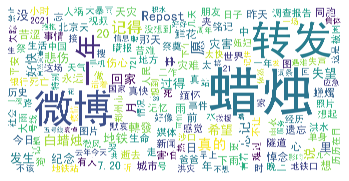

In [286]:
wordcloud=WordCloud(width = 1000, height = 500,font_path='D:\Anaconda\Lib\site-packages\wordcloud\simhei.ttf',collocations=True,background_color='white',scale=20)
wordcloud=wordcloud.generate_from_frequencies(wordcount)
plt.imshow(wordcloud)
plt.axis("off")
plt.show()
wordcloud.to_file('wd.jpg')